# ByoTrack fundamental features

In [1]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

import byotrack
import byotrack.visualize

## Loading a video 

In [2]:
video_path = "path/to/video.ext"

# Simply open a video
video = byotrack.Video(video_path)

fps = 20
# fps = video.reader.fps

# Note: video could also be a 4 dimensionnal numpy array loaded manually

In [3]:
TEST = True  # Set to False to analyze a whole video

if TEST:
    video = video[:50]  # Temporal slicing to analyze only the first 50 frames

In [4]:
# A transform can be added to normalize and aggregate channels

transform_config = byotrack.VideoTransformConfig(aggregate=True, normalize=True, q_min=0.01, q_max=0.995, smooth_clip=1.0)
video.set_transform(transform_config)

# Show the min max value used to clip and normalize
print(video._normalizer.mini, video._normalizer.maxi)

[401.] [843.]


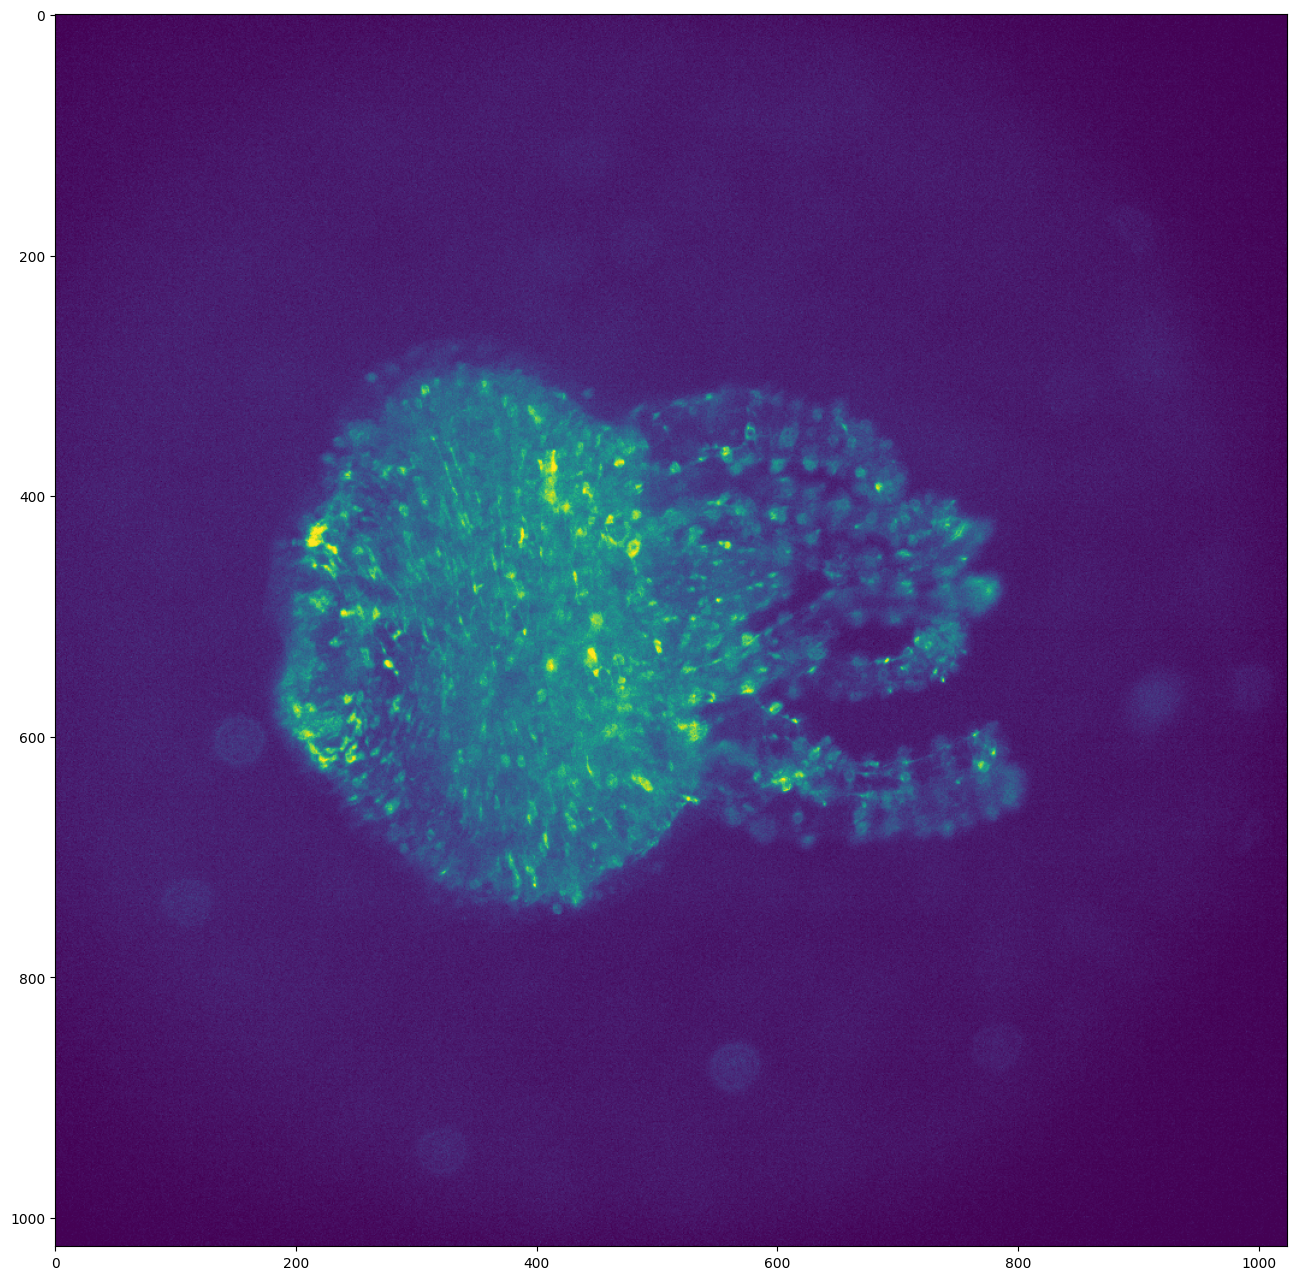

In [5]:
# Display the first frame

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(video[0])
plt.show()

In [6]:
# Visualization
# Use w/x to move forward in time (or space to run/pause the video)

byotrack.visualize.InteractiveVisualizer(video).run()

## Detections on a video: Example of WaveletDetector

In [7]:
# Create the detector object with its hyper parameters
from byotrack.implementation.detector.wavelet import WaveletDetector

detector = WaveletDetector(scale=1, k=3.0, min_area=3.0, batch_size=20, device=torch.device("cpu"))

In [8]:
# Run the detection process on the current video

detections_sequence = detector.run(video)

Detections (Wavelet):   0%|          | 0/50 [00:00<?, ?it/s]

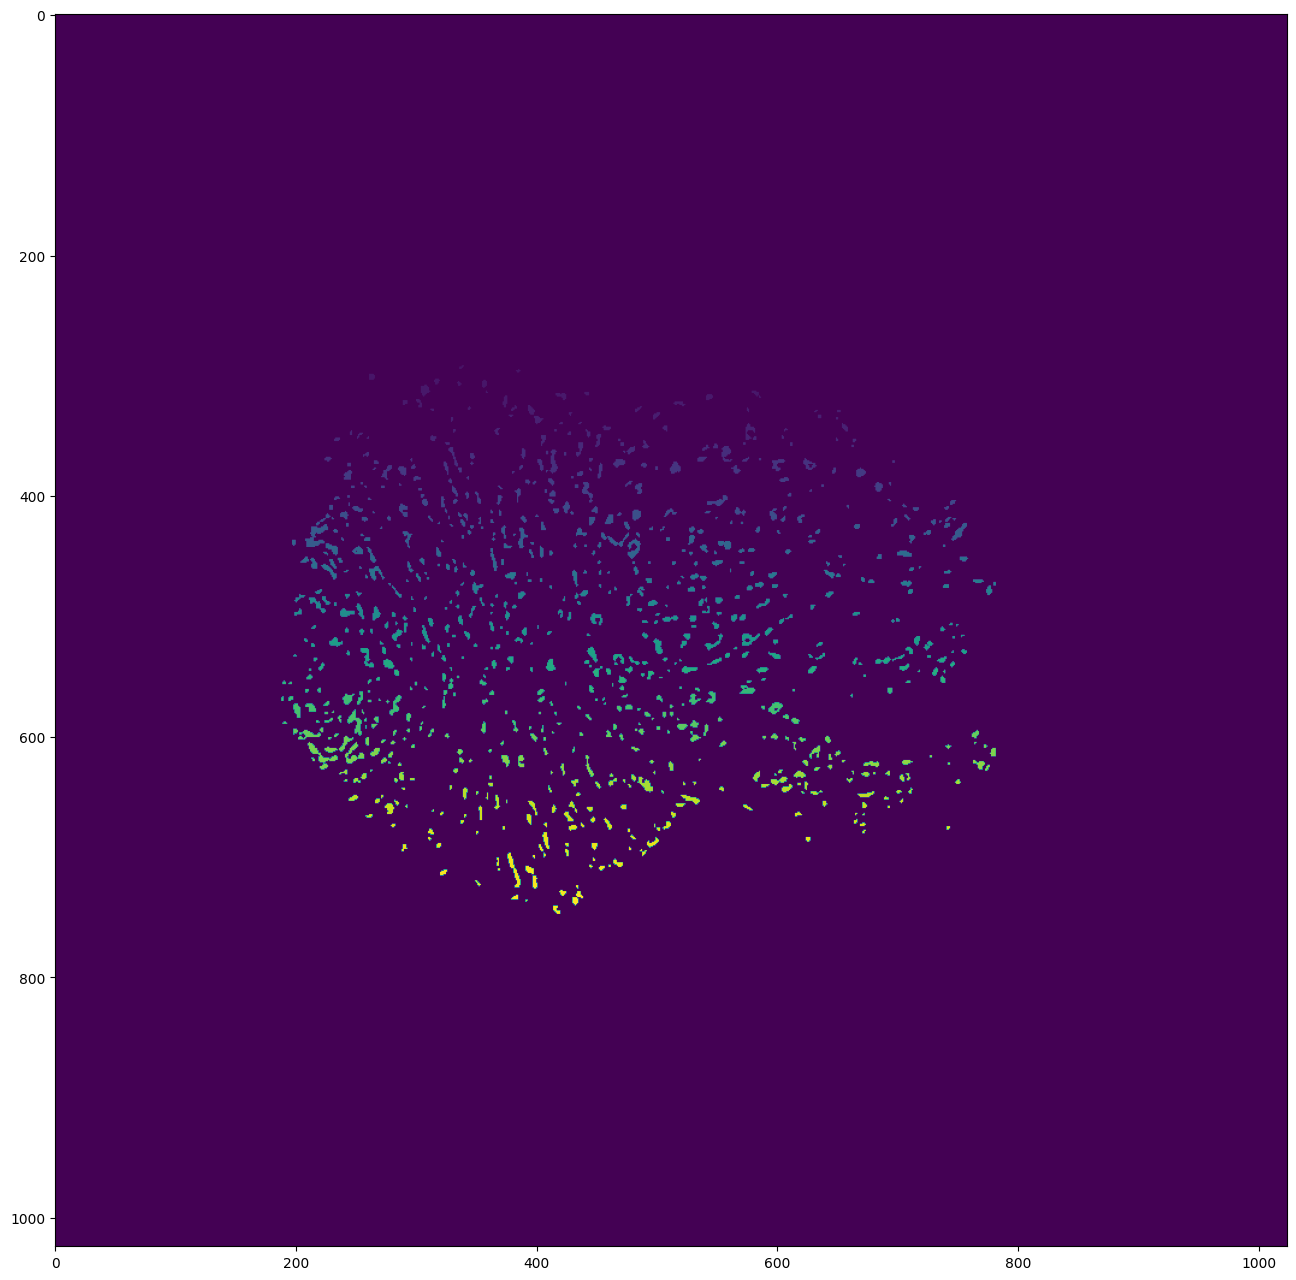

In [9]:
# Display the first detections

segmentation = detections_sequence[0].segmentation.clone()
segmentation[segmentation!=0] += 50  # Improve visibility of firsts labels

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(segmentation)
plt.show()

In [10]:
# Display the detections with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use v to switch on/off the display of the video
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence).run()

In [11]:
# Set hyperparameters manually on the video
# Use w/x to move backward/forward in the video
# Use c/v to update k (the main hyperparameter)
# You can restard with another scale/min_area

K_SPEED = 0.01

i = 0
detector = WaveletDetector(scale=1, k=3.0, min_area=3.0, device=torch.device("cpu"))

while True:
    frame = video[i]
    detections = detector.detect(frame[None, ...])[0]
    mask = (detections.segmentation.numpy() != 0).astype(np.uint8) * 255

    # Display the resulting frame
    cv2.imshow('Frame', mask)
    cv2.setWindowTitle('Frame', f'Frame {i} / {len(video)} - k={detector.k} - Num detections: {detections.length}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey() & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break

    if key == ord("w"):
        i = (i - 1) % len(video)

    if key == ord("x"):
        i = (i + 1) % len(video)

    if key == ord("c"):
        detector.k = detector.k * (1 - K_SPEED)

    if key == ord("v"):
        detector.k = detector.k * (1 + K_SPEED)


cv2.destroyAllWindows()

## Link detections: Example of IcyEMHTLinker

In [12]:
from byotrack.implementation.linker.icy_emht import IcyEMHTLinker, Motion, EMHTParameters

# Create the linker object with icy path
# This Linker requires to install Icy software first

icy_path = "path/to/icy/icy.jar"
motion = Motion.MULTI  # Can also be DIRECTED or MULTI (both)

if True:  # Set full specs with EMHTParameters
    # You can choose to set manually the parameters. See EMHTParameters
    # the more important ones are:
    # - gate_factor: How greedy the linking is. (Default to 4.0)
    # - motion: Motion model to consider: Can be BROWNIAN, DIRECTED or MULTI. (Default is BROWNIAN)
    # - tree_depth: MHT tree depth. Higher values are usually more performant, but much more expensive
    #             If the tracking is too slow or too ram intensive, you may reduce this value. (Default 4)
    parameters = EMHTParameters(gate_factor=4.0, motion=motion, tree_depth=2)
    linker = IcyEMHTLinker(icy_path, parameters)
else:  # Do not provide specs, parameters will be estimated by Icy
    linker = IcyEMHTLinker(icy_path)
    linker.motion = motion  # Set motion afterwards if no parameters are provided

In [13]:
# Run the linker given a video (Unused for icy_emht) and detections

tracks = linker.run(video, detections_sequence)

Calling Icy with: java -jar icy.jar -hl -x plugins.adufour.protocols.Protocols protocol=/home/rreme/workspace/pasteur/byotrack/byotrack/implementation/linker/icy_emht/emht_protocol_with_full_specs.xml rois=/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_rois.xml parameters=/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_parameters.xml tracks=/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_tracks.xml
[DEBUG] 2024-06-18 17:14:14 - Initializing...


JarResources.loadJar(/home/rreme/workspace/pasteur/icy-app-v3/plugins/nchenouard/particletracking/sequenceGenerator/._tracking-benchmark-generator-2.0.0.jar) error:
java.util.zip.ZipException: zip END header not found



[INFO] 2024-06-18 17:14:14 - Java(TM) SE Runtime Environment 21.0.1+12-LTS-29 (64 bit)
[INFO] 2024-06-18 17:14:14 - Running on Linux 5.15.0-107-generic (amd64)
[INFO] 2024-06-18 17:14:14 - System total memory: 32.6 GB
[INFO] 2024-06-18 17:14:14 - System available memory: 5.8 GB
[INFO] 2024-06-18 17:14:14 - Max Java memory: 8.2 GB
[INFO] 2024-06-18 17:14:15 - Headless mode.
[INFO] 2024-06-18 17:14:15 - Icy v3.0.0a started.
[DEBUG] 2024-06-18 17:14:15 - Magic name is Spot Tracking
[DEBUG] 2024-06-18 17:14:15 - Magic icon is /plugins/nchenouard/particletracking/simplifiedMHT/detectionIcon.png
[DEBUG] 2024-06-18 17:14:15 - Magic name is EzPlug tutorial
[DEBUG] 2024-06-18 17:14:15 - Magic icon is /plugins/adufour/ezplug/ezplug.png
Loading workflow...


Error(s) while loading protocol:
Variable 'useLPSolver' not found in block 'Spot tracking do tracking'. It may have been removed or renamed.
--


Converted from 38830 ROI(s)
Non binaryaction at frame 2
Non binaryaction at frame 3
Non binaryaction at frame 5
Non binaryaction at frame 9
Non binaryaction at frame 12
Non binaryaction at frame 15
Non binaryaction at frame 20
Non binaryaction at frame 22
Non binaryaction at frame 26
Non binaryaction at frame 27
Non binaryaction at frame 29
Non binary
Non binaryaction at frame 32
Non binaryaction at frame 34
Non binary
Non binary
Non binaryaction at frame 40
Non binaryaction at frame 42
Non binaryaction at frame 43
Non binary
Non binaryaction at frame 46
Non binaryaction at frame 47
Non binary
Non binary
Non binaryaction at frame 49
Non binary
Non binary

[INFO] 2024-06-18 17:14:41 - Exiting...
[INFO] 2024-06-18 17:14:41 - Done.


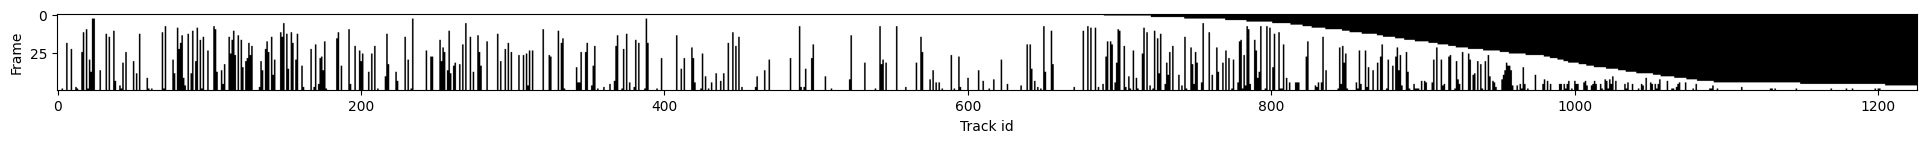

In [14]:
# Visualize track lifetime

# Each track is in white when it alive. (Track on x-axis, time on y-axis)

byotrack.visualize.display_lifetime(tracks)

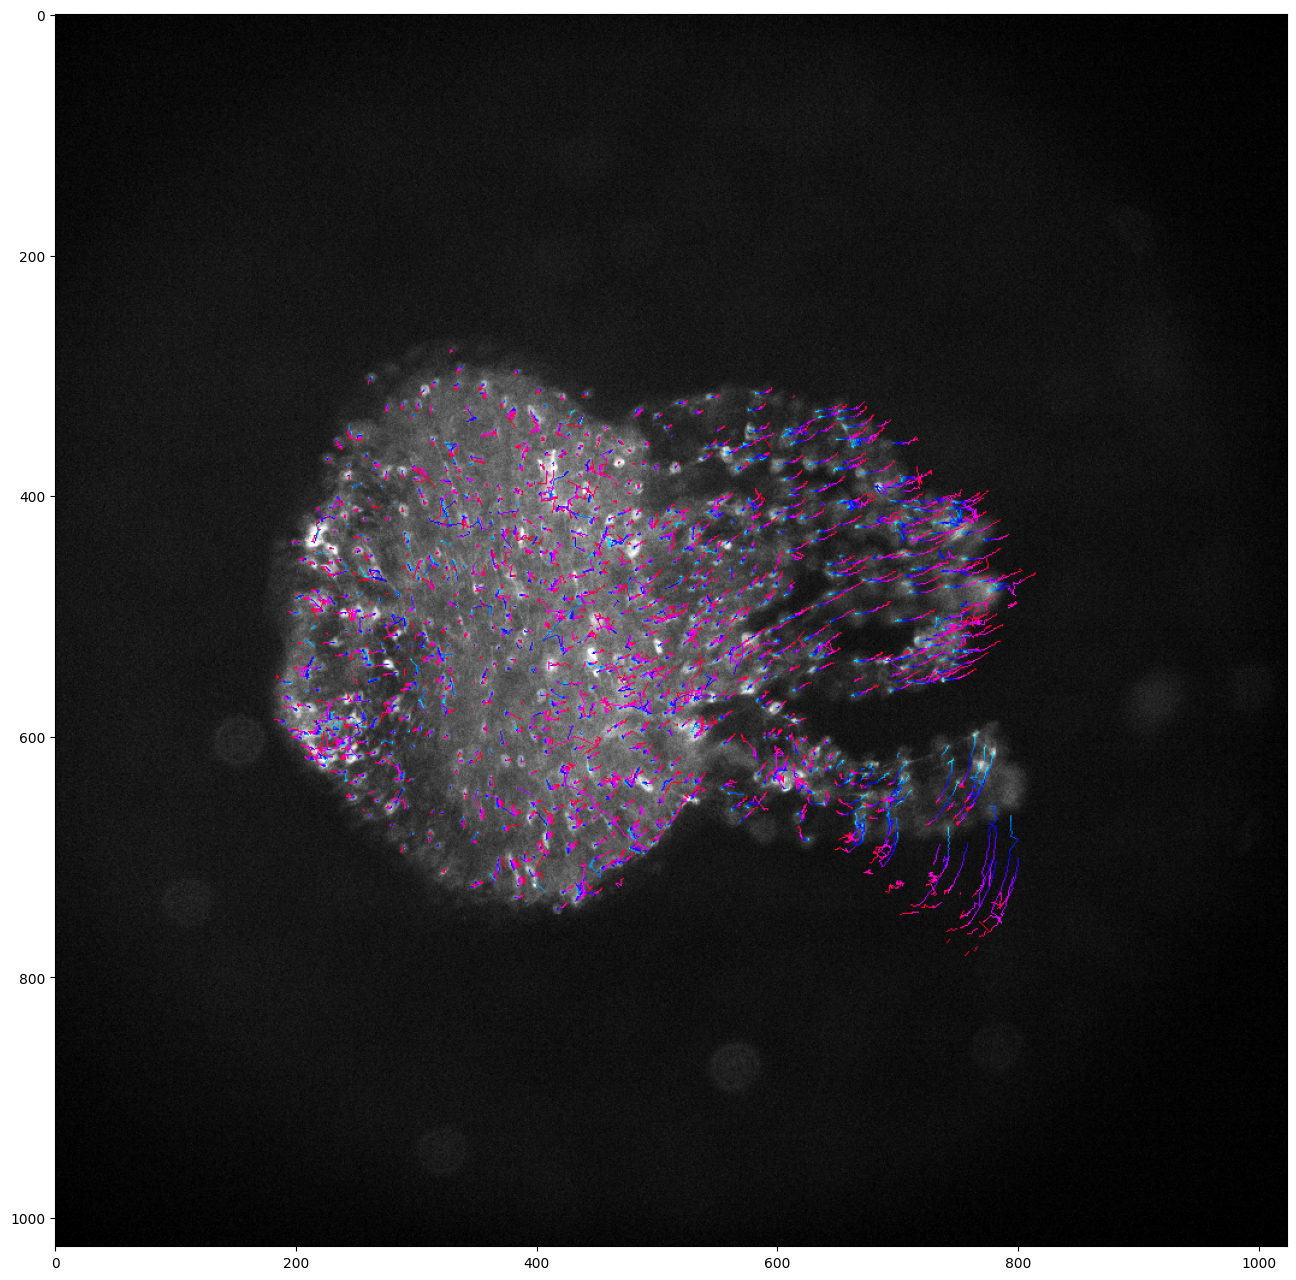

In [15]:
# Project tracks onto a single image and color by time

# Create a list of colors for each time frame
# From cyan (start of the video) to red (end of the video)

hsv = mpl.colormaps["hsv"]
colors = [tuple(int(c * 255) for c in hsv(0.5 + 0.5 * k / (len(detections_sequence) - 1))[:3]) for k in range(len(detections_sequence))]

visu = byotrack.visualize.temporal_projection(
    byotrack.Track.tensorize(tracks),
    colors=colors,
    background=video[0],
    color_by_time=True
)

plt.figure(figsize=(24, 16))
plt.imshow(visu)
plt.show()

In [16]:
# Display the tracks with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use v (resp. t) to switch on/off the display of video (resp. tracks)
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence, tracks).run()

## Tracks refinement: Example of Cleaner, followed by EMC2 Stitcher

In [17]:
from byotrack.implementation.refiner.cleaner import Cleaner
from byotrack.implementation.refiner.stitching import EMC2Stitcher

In [18]:
# Split tracks with consecutive dist > 3.5
# Drop tracks with length < 5

cleaner = Cleaner(min_length=5, max_dist=3.5)
tracks = cleaner.run(video, tracks)

Cleaning: Split 1859 tracks and dropped 1471 resulting ones
Cleaning: From 1226 to 1614 tracks


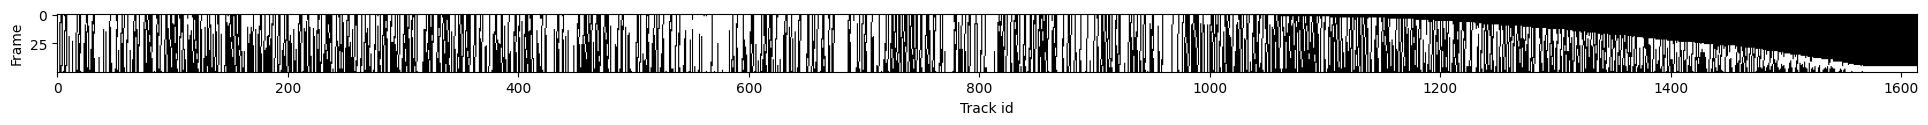

In [19]:
# Visualize track lifetime

byotrack.visualize.display_lifetime(tracks)

In [20]:
# Stitch tracks together in order to produce coherent track on all the video

stitcher = EMC2Stitcher(eta=5.0)  # Don't link tracks if they are too far (EMC dist > 5 (pixels))
tracks = stitcher.run(video, tracks)

TPS forward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

TPS backward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

Merging 1614 tracks into 1133 resulting tracks


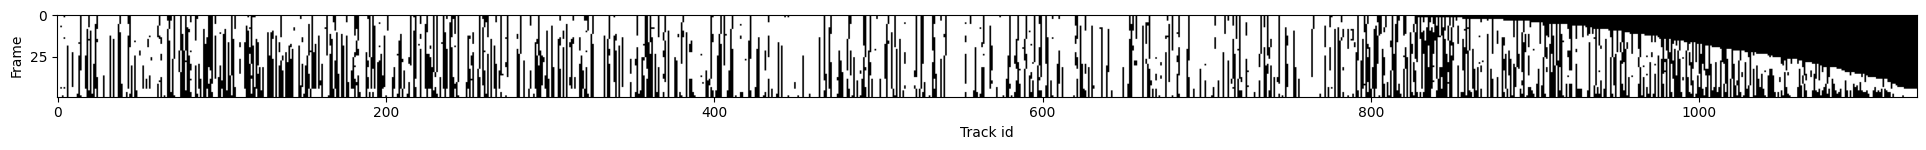

In [21]:
# Visualize track lifetime

byotrack.visualize.display_lifetime(tracks)

## End-to-end tracking: Example of MultiStepTracker

In [22]:
from byotrack import MultiStepTracker

In [23]:
# Create all the steps: Detector, Linker[, Refiner]
# Then the tracker

detector = WaveletDetector(scale=1, k=3, min_area=3.0, batch_size=20, device=torch.device("cpu"))
linker = IcyEMHTLinker(icy_path, EMHTParameters(gate_factor=4.0, motion=motion, tree_depth=2))

# Optional refiner
refiners = []
if True:
    refiners = [Cleaner(5, 3.5), EMC2Stitcher(eta=5.0)]

tracker = MultiStepTracker(detector, linker, refiners)

In [24]:
tracks = tracker.run(video)

Detections (Wavelet):   0%|          | 0/50 [00:00<?, ?it/s]

Calling Icy with: java -jar icy.jar -hl -x plugins.adufour.protocols.Protocols protocol=/home/rreme/workspace/pasteur/byotrack/byotrack/implementation/linker/icy_emht/emht_protocol_with_full_specs.xml rois=/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_rois.xml parameters=/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_parameters.xml tracks=/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_tracks.xml
[DEBUG] 2024-06-18 17:17:45 - Initializing...


JarResources.loadJar(/home/rreme/workspace/pasteur/icy-app-v3/plugins/nchenouard/particletracking/sequenceGenerator/._tracking-benchmark-generator-2.0.0.jar) error:
java.util.zip.ZipException: zip END header not found



[INFO] 2024-06-18 17:17:45 - Java(TM) SE Runtime Environment 21.0.1+12-LTS-29 (64 bit)
[INFO] 2024-06-18 17:17:45 - Running on Linux 5.15.0-107-generic (amd64)
[INFO] 2024-06-18 17:17:45 - System total memory: 32.6 GB
[INFO] 2024-06-18 17:17:45 - System available memory: 5.5 GB
[INFO] 2024-06-18 17:17:45 - Max Java memory: 8.2 GB
[INFO] 2024-06-18 17:17:46 - Headless mode.
[INFO] 2024-06-18 17:17:46 - Icy v3.0.0a started.
[DEBUG] 2024-06-18 17:17:46 - Magic name is Spot Tracking
[DEBUG] 2024-06-18 17:17:46 - Magic icon is /plugins/nchenouard/particletracking/simplifiedMHT/detectionIcon.png
[DEBUG] 2024-06-18 17:17:46 - Magic name is EzPlug tutorial
[DEBUG] 2024-06-18 17:17:46 - Magic icon is /plugins/adufour/ezplug/ezplug.png
Loading workflow...


Error(s) while loading protocol:
Variable 'useLPSolver' not found in block 'Spot tracking do tracking'. It may have been removed or renamed.
--


Converted from 38830 ROI(s)
Non binaryaction at frame 2
Non binaryaction at frame 3
Non binaryaction at frame 5
Non binaryaction at frame 9
Non binaryaction at frame 12
Non binaryaction at frame 15
Non binaryaction at frame 20
Non binaryaction at frame 22
Non binaryaction at frame 26
Non binaryaction at frame 27
Non binaryaction at frame 29
Non binary
Non binaryaction at frame 32
Non binaryaction at frame 34
Non binary
Non binary
Non binaryaction at frame 40
Non binaryaction at frame 42
Non binaryaction at frame 43
Non binary
Non binaryaction at frame 46
Non binaryaction at frame 47
Non binary
Non binaryaction at frame 49
Non binary
Non binary

[INFO] 2024-06-18 17:18:13 - Exiting...
[INFO] 2024-06-18 17:18:13 - Done.
Cleaning: Split 1859 tracks and dropped 1471 resulting ones
Cleaning: From 1226 to 1614 tracks


TPS forward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

TPS backward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

Merging 1614 tracks into 1133 resulting tracks


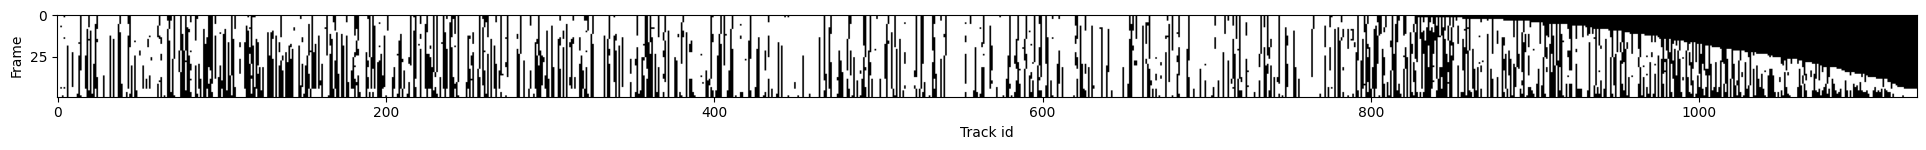

In [25]:
# Visualize track lifetime

byotrack.visualize.display_lifetime(tracks)

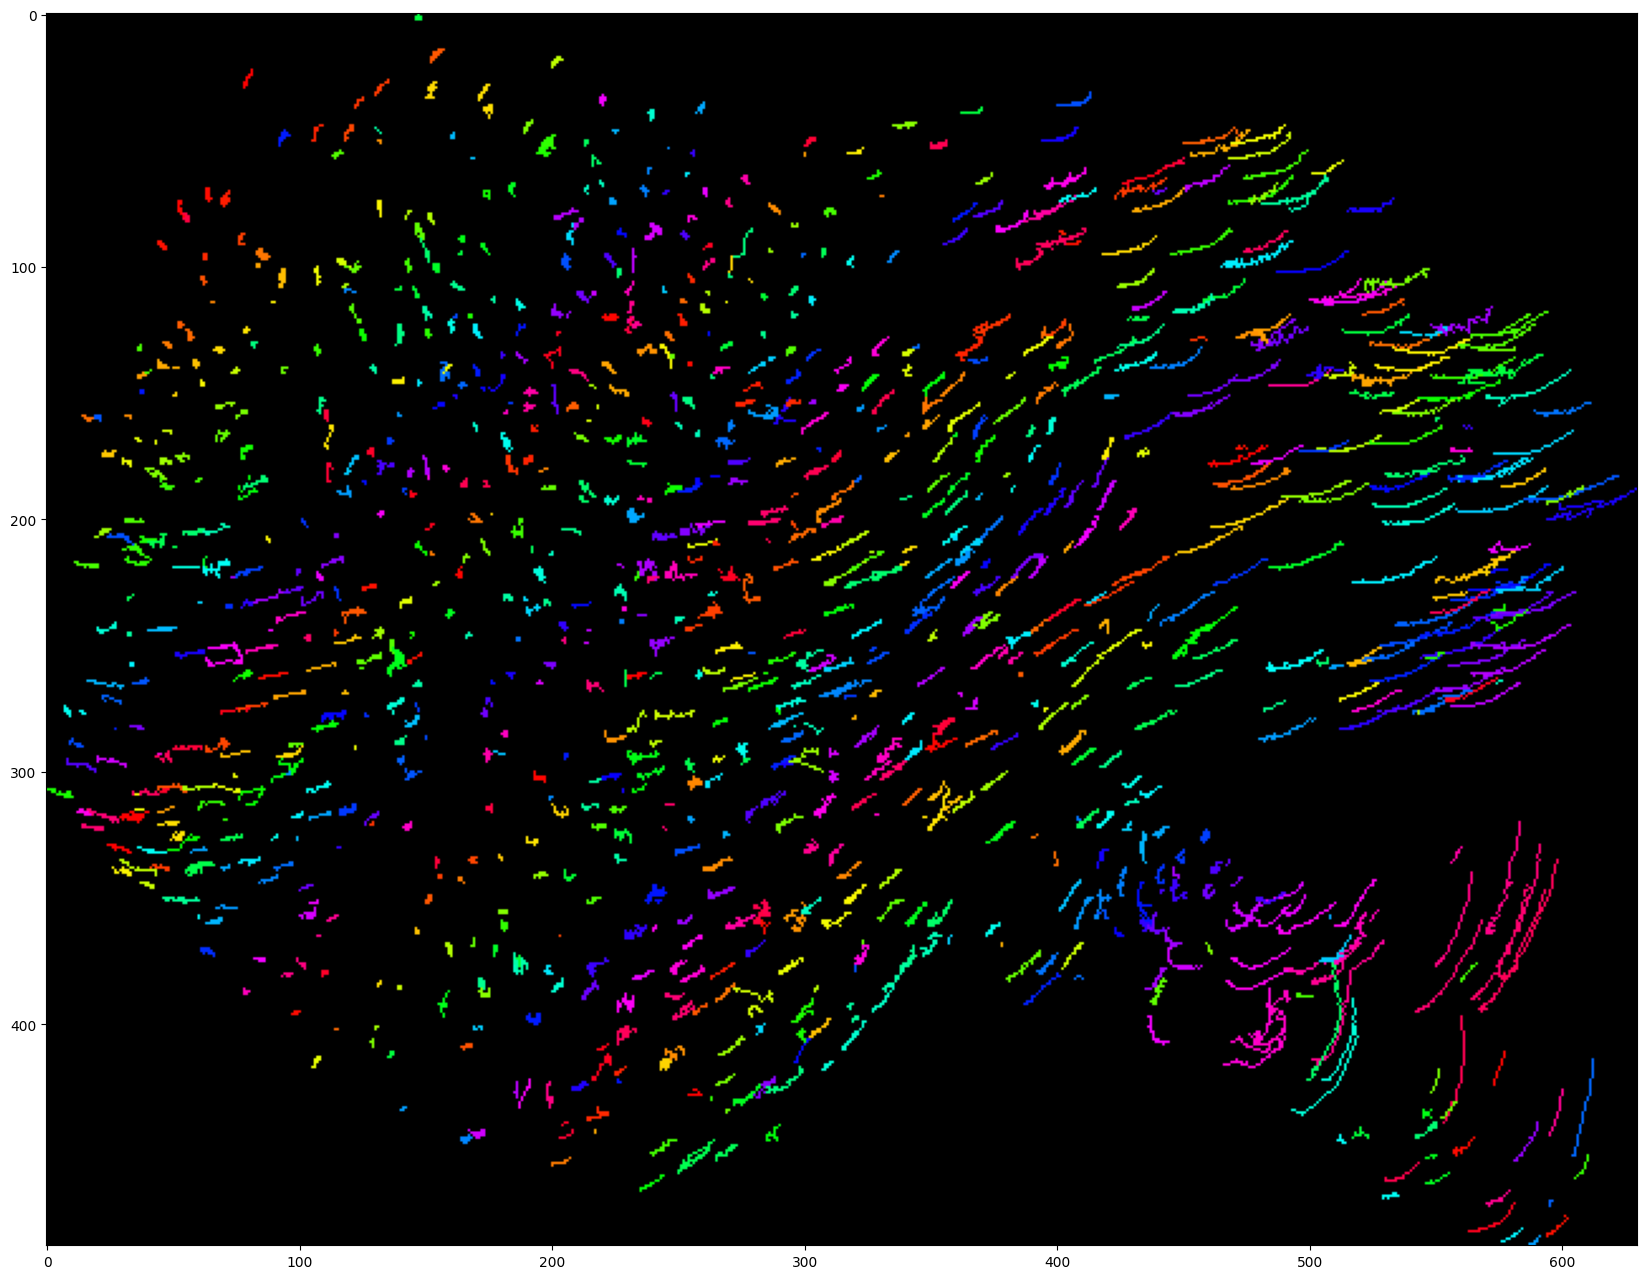

In [26]:
# Project tracks onto a single image and color by track

# Create a list of colors for each track (if more tracks than colors, it will cycle through it)

hsv = mpl.colormaps["hsv"]
colors = [tuple(int(c * 255) for c in hsv(k / 199)[:3]) for k in range(200)]

visu = byotrack.visualize.temporal_projection(
    byotrack.Track.tensorize(tracks),
    colors=colors,
)

plt.figure(figsize=(24, 16))
plt.imshow(visu)
plt.show()

In [27]:
# Display the tracks with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use v (resp. t) to switch on/off the display of video (resp. tracks)
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence, tracks).run()

## Postprocessing: Fill NaN with interpolated values

In [28]:
from byotrack.implementation.refiner.interpolater import ForwardBackwardInterpolater

In [29]:
# After EMC2 stitching, NaN values can be inside merged tracks.
# It can be filled with interpolation between known positions

# Note that you can add this refiner to your MultiStepTracker pipeline

method = "tps"  # tps / constant / flow (You need to provided a valid byotrack.OpticalFlow then)
full = False  # Extrapolate position of the tracks on the all frame range and not just for the track lifespan

tracks = ForwardBackwardInterpolater(method, full).run(video, tracks)

TPS forward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

TPS backward propagation:   0%|          | 0/49 [00:00<?, ?it/s]

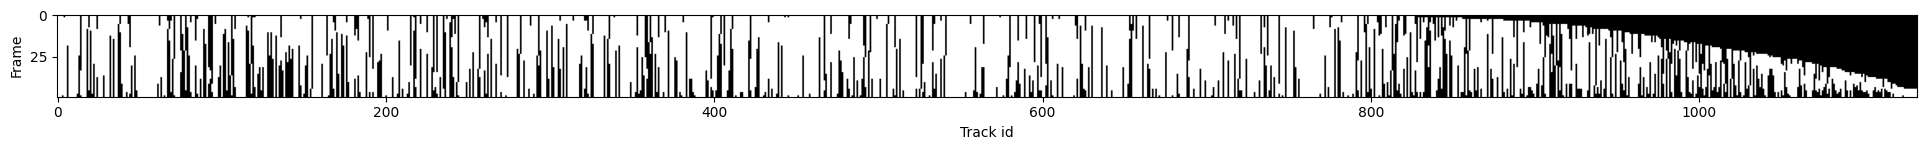

In [30]:
# Visualize track lifetime

byotrack.visualize.display_lifetime(tracks)

## Load or save tracks to files

In [31]:
# Save tracks in ByoTrack format (compressed in a torch tensor)

byotrack.Track.save(tracks, "tracks.pt")

# Can be reload with
tracks = byotrack.Track.load("tracks.pt")

In [32]:
# We also provide IO with Icy software

from byotrack import icy


icy.save_tracks(tracks, "tracks.xml")  # Note that holes should should be filled first with the ForwardBackwardInterpolater

# You can (re)load tracks from icy with
tracks = icy.load_tracks("tracks.xml")